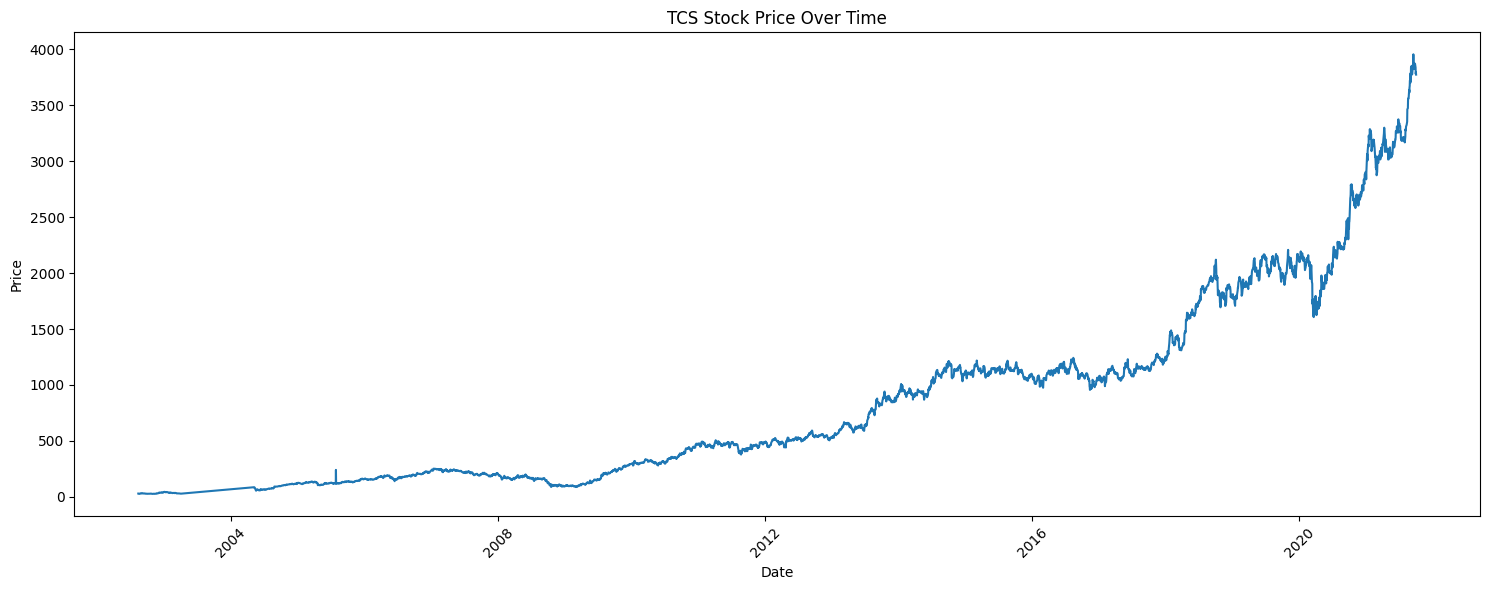

In [5]:
# Plot stock price over time            

plt.figure(figsize=(15, 6))
plt.plot(merged_df['Date'], merged_df['Close'])
plt.title('TCS Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

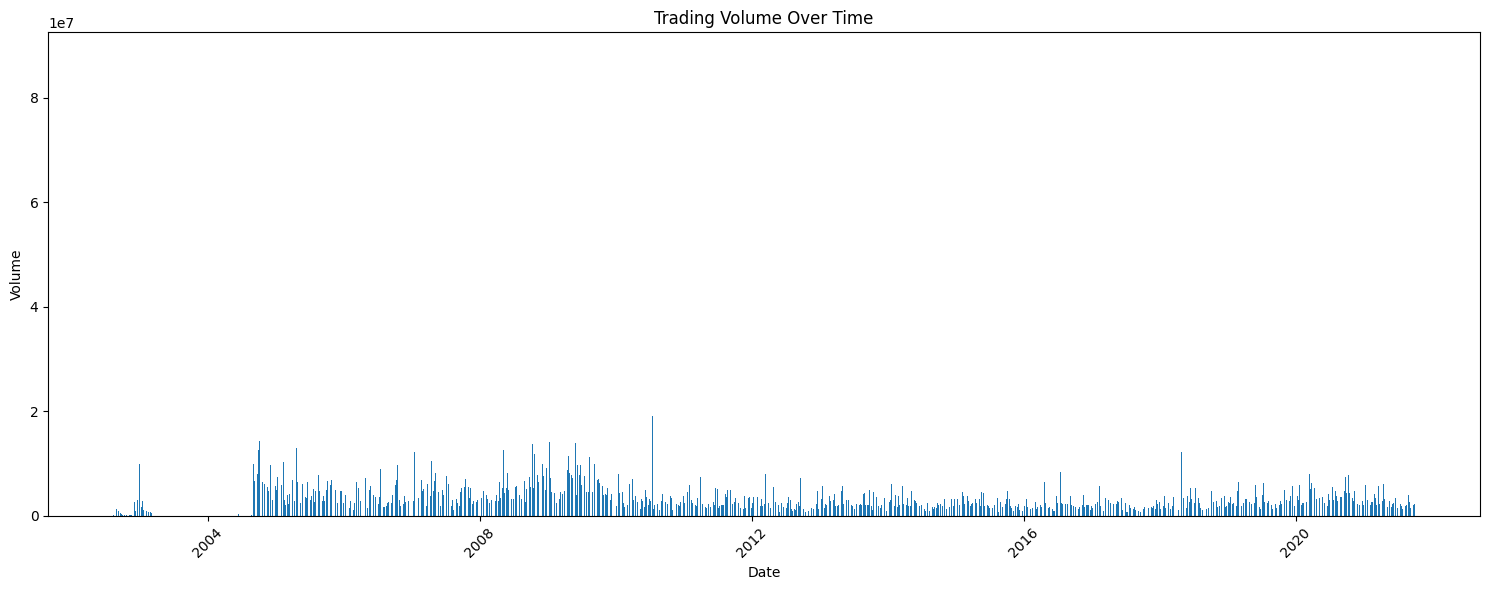

In [6]:
# Plot trading volume

plt.figure(figsize=(15, 6))
plt.bar(merged_df['Date'], merged_df['Volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

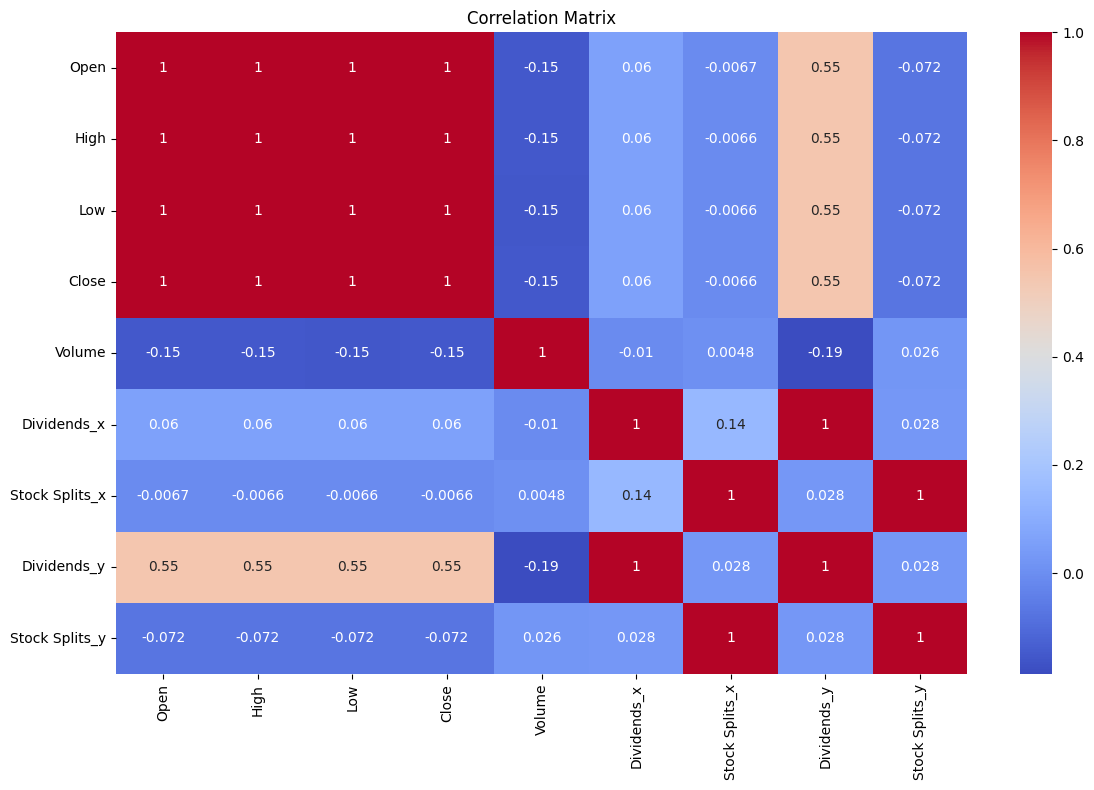

In [7]:
# Correlation heatmap

numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
correlation_matrix = merged_df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [13]:
# Create features
def create_features(df):
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    return df

# Apply feature engineering
merged_df = create_features(merged_df)
merged_df = merged_df.dropna()

# Display the features we created
print("Features in the dataset:")
print(merged_df.columns.tolist())
print("\nFirst few rows of the processed data:")
print(merged_df.head())

# Prepare data for LSTM
def prepare_data(df, sequence_length=60):
    # Select features
    features = ['Close', 'Volume', 'Returns', 'MA5', 'MA20', 'Volatility']
    
    # Verify all features exist in the dataframe
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing features in dataframe: {missing_features}")
    
    # Extract the data
    data = df[features].values
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])  # Close price is the first column
    
    # Convert to numpy arrays and reshape if necessary
    X = np.array(X)
    y = np.array(y)
    
    # Print shapes for debugging
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y, scaler

# Split data into train and test sets
train_size = int(len(merged_df) * 0.8)
train_data = merged_df[:train_size]
test_data = merged_df[train_size:]

# Prepare the data
X_train, y_train, scaler = prepare_data(train_data)
X_test, y_test, _ = prepare_data(test_data)

# Print final shapes
print("\nFinal data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Features in the dataset:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends_x', 'Stock Splits_x', 'Dividends_y', 'Stock Splits_y', 'Returns', 'MA5', 'MA20', 'Volatility']

First few rows of the processed data:
           Date         Open         High          Low        Close   Volume  \
2757 2014-10-29  1084.009474  1101.090835  1083.133507  1097.608887  2425016   
2817 2015-01-27  1102.570085  1103.733021  1092.564054  1098.049805  2738736   
2904 2015-06-05  1148.100213  1155.630192  1138.355536  1140.946777  2308534   
2935 2015-07-20  1138.138850  1146.972256  1132.767715  1144.863770   853786   
2999 2015-10-21  1130.186318  1133.307148  1124.501949  1127.957153  1929688   

      Dividends_x  Stock Splits_x  Dividends_y  Stock Splits_y   Returns  \
2757         2.50             0.0         2.50             0.0 -0.030195   
2817         2.50             0.0         2.50             0.0  0.000402   
2904        12.00             0.0        12.00             0.0  0.0390

In [15]:
# First, let's print the shape of our data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Build LSTM model with correct input shape
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Let's modify the data preparation to ensure correct shapes
def prepare_data(df, sequence_length=60):
    # Select features
    features = ['Close', 'Volume', 'Returns', 'MA5', 'MA20', 'Volatility']
    
    # Verify all features exist in the dataframe
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing features in dataframe: {missing_features}")
    
    # Extract the data
    data = df[features].values
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])  # Close price is the first column
    
    # Convert to numpy arrays and ensure correct shape
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)  # Reshape y to (n_samples, 1)
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y, scaler

# Split data into train and test sets
train_size = int(len(merged_df) * 0.8)
train_data = merged_df[:train_size]
test_data = merged_df[train_size:]

# Prepare the data
X_train, y_train, scaler = prepare_data(train_data)
X_test, y_test, _ = prepare_data(test_data)

# Print shapes for verification
print("\nFinal data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Create and train the model with correct input shape
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

X_train shape: (0,)
y_train shape: (0,)
X shape: (0,)
y shape: (0, 1)
X shape: (0,)
y shape: (0, 1)

Final data shapes:
X_train shape: (0,)
y_train shape: (0, 1)
X_test shape: (0,)
y_test shape: (0, 1)


IndexError: tuple index out of range

In [16]:
# Add this after data preparation to verify the data
print("\nSample of prepared data:")
print("X_train sample shape:", X_train[0].shape)
print("X_train sample:", X_train[0][:5])  # First 5 timesteps of first sequence
print("y_train sample:", y_train[:5])  # First 5 target values


Sample of prepared data:


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
"# Make predictions\n",
    "train_predictions = model.predict(X_train)\n",
    "test_predictions = model.predict(X_test)\n",
    "\n",
    "# Inverse transform predictions\n",
    "train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((len(train_predictions), 5))), axis=1))[:, 0]\n",
    "test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((len(test_predictions), 5))), axis=1))[:, 0]\n",
    "\n",
    "# Calculate metrics\n",
    "train_rmse = np.sqrt(mean_squared_error(train_data['Close'].values[60:], train_predictions))\n",
    "test_rmse = np.sqrt(mean_squared_error(test_data['Close'].values[60:], test_predictions))\n",
    "\n",
    "print(f'Train RMSE: {train_rmse:.2f}')\n",
    "print(f'Test RMSE: {test_rmse:.2f}')\n",
    "\n",

  "# Plot predictions\n",
    "plt.figure(figsize=(15, 6))\n",
    "plt.plot(test_data['Date'].values[60:], test_data['Close'].values[60:], label='Actual')\n",
    "plt.plot(test_data['Date'].values[60:], test_predictions, label='Predicted')\n",
    "plt.title('TCS Stock Price Prediction')\n",
    "plt.xlabel('Date')\n",
    "plt.ylabel('Price')\n",
    "plt.legend()\n",
    "plt.xticks(rotation=45)\n",
    "plt.tight_layout()\n",
    "plt.show()\n",
    "\n",
    "# Plot training history\n",
    "plt.figure(figsize=(10, 6))\n",
    "plt.plot(history.history['loss'], label='Training Loss')\n",
    "plt.plot(history.history['val_loss'], label='Validation Loss')\n",
    "plt.title('Model Loss During Training')\n",
    "plt.xlabel('Epoch')\n",
    "plt.ylabel('Loss')\n",
    "plt.legend()\n",
    "plt.tight_layout()\n",
    "plt.show()"
   ]

In [ ]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import pickle

In [14]:
# Load CSVs
df_history = pd.read_csv('TCS_stock_history.csv')
df_action = pd.read_csv('TCS_stock_action.csv')
df_info = pd.read_csv('TCS_stock_info.csv')

In [15]:
df_history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [17]:
df_action.head()

,Date,Dividends,Stock Splits
0,2004-10-28,0.3750,0.0
1,2005-02-03,0.4375,0.0
2,2005-07-06,0.6250,0.0
3,2005-08-18,0.3750,0.0
4,2005-10-18,0.3750,0.0


In [ ]:

df_info.head()

,zip,400001
0,sector,Technology
1,fullTimeEmployees,509058
2,longBusinessSummary,Tata Consultancy Services Limited provides inf...
3,city,Mumbai
4,phone,91 22 6778 9999


In [18]:
# Prepare dates
df_history['Date'] = pd.to_datetime(df_history['Date'])
df_action['Date'] = pd.to_datetime(df_action['Date'])

In [19]:
df_history.sort_values('Date', inplace=True)
df_action.sort_values('Date', inplace=True)

In [20]:
# Merge
df_merged = pd.merge(df_history, df_action, on='Date', how='left')
df_merged.rename(columns={
    'Dividends': 'Recorded_Dividend',
    'Stock Splits': 'Recorded_Stock_Split',
    'Stock Split': 'Action_Stock_Split'
}, inplace=True)

In [22]:
df_merged.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends_x',
       'Stock Splits_x', 'Dividends_y', 'Stock Splits_y'],
      dtype='object')

In [23]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            4463 non-null   datetime64[ns]
 1   Open            4463 non-null   float64       
 2   High            4463 non-null   float64       
 3   Low             4463 non-null   float64       
 4   Close           4463 non-null   float64       
 5   Volume          4463 non-null   int64         
 6   Dividends_x     4463 non-null   float64       
 7   Stock Splits_x  4463 non-null   float64       
 8   Dividends_y     70 non-null     float64       
 9   Stock Splits_y  70 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 348.8 KB


In [24]:
df_merged.describe

<bound method NDFrame.describe of            Date         Open         High          Low        Close   Volume  \
0    2002-08-12    28.794172    29.742206    28.794172    29.519140   212976   
1    2002-08-13    29.556316    30.030333    28.905705    29.119476   153576   
2    2002-08-14    29.184536    29.184536    26.563503    27.111877   822776   
3    2002-08-15    27.111877    27.111877    27.111877    27.111877        0   
4    2002-08-16    26.972458    28.255089    26.582090    27.046812   811856   
...         ...          ...          ...          ...          ...      ...   
4458 2021-09-24  3890.000000  3944.399902  3855.000000  3871.300049  2320754   
4459 2021-09-27  3900.000000  3904.000000  3802.899902  3836.949951  1673362   
4460 2021-09-28  3850.000000  3850.000000  3751.250000  3779.149902  2253075   
4461 2021-09-29  3759.800049  3806.000000  3722.149902  3791.899902  2489161   
4462 2021-09-30  3805.000000  3805.000000  3765.000000  3773.199951   640479   

     

In [25]:
df_merged.describe()

,Date,Open,High,Low,Close,Volume,Dividends_x,Stock Splits_x,Dividends_y,Stock Splits_y
count,4463,4463.000000,4463.000000,4463.000000,4463.000000,4.463000e+03,4463.000000,4463.000000,70.000000,70.000000
mean,2012-08-23 19:22:31.109119488,866.936239,876.675013,856.653850,866.537398,3.537876e+06,0.071533,0.001344,4.560714,0.085714
min,2002-08-12 00:00:00,24.146938,27.102587,24.146938,26.377609,0.000000e+00,0.000000,0.000000,0.375000,0.000000
25%,2008-02-14 12:00:00,188.951782,191.571816,185.979417,188.594620,1.860959e+06,0.000000,0.000000,1.000000,0.000000
50%,2012-09-04 00:00:00,530.907530,534.751639,525.616849,529.713257,2.757742e+06,0.000000,0.000000,2.500000,0.000000
75%,2017-03-22 12:00:00,1156.462421,1165.815854,1143.622800,1154.784851,4.278625e+06,0.000000,0.000000,5.000000,0.000000
max,2021-09-30 00:00:00,3930.000000,3981.750000,3892.100098,3954.550049,8.806715e+07,40.000000,2.000000,40.000000,2.000000
std,NaN,829.905368,838.267104,821.233477,829.611313,3.273531e+06,0.965401,0.051842,6.284794,0.407995


In [26]:
# Check % of NaN values in each column
nan_percentage = df_merged.isna().mean() * 100
print("NaN Percentage by Column:\n")
print(nan_percentage[nan_percentage > 0].sort_values(ascending=False))


NaN Percentage by Column:

Dividends_y       98.431548
Stock Splits_y    98.431548
dtype: float64


In [28]:
df_merged.drop(columns=['Dividends_y', 'Stock Splits_y'], inplace=True)
df_merged.rename(columns={
    'Dividends_x': 'Dividends',
    'Stock Splits_x': 'Stock Splits'
}, inplace=True)


KeyError: "['Dividends_y', 'Stock Splits_y'] not found in axis"

In [29]:
if 'Dividend' in df_merged.columns:
    df_merged['Dividend'] = df_merged['Dividend'].fillna(0)
if 'Stock Split' in df_merged.columns:
    df_merged['Stock Split'] = df_merged['Stock Split'].fillna(0)

In [30]:
# Feature Engineering
def create_features(df):
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    df['RSI'] = compute_rsi(df['Close'], 14)
    return df

In [31]:
# RSI calculation
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [32]:
df_merged = create_features(df_merged)
df_merged.dropna(inplace=True)

In [33]:
# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'Returns', 'MA5', 'MA20', 'EMA10', 'Volatility', 'RSI']
target = 'Close'

In [34]:
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_merged[features])
y = df_merged[target].values

Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error: 799.10
R2 Score: -1.79


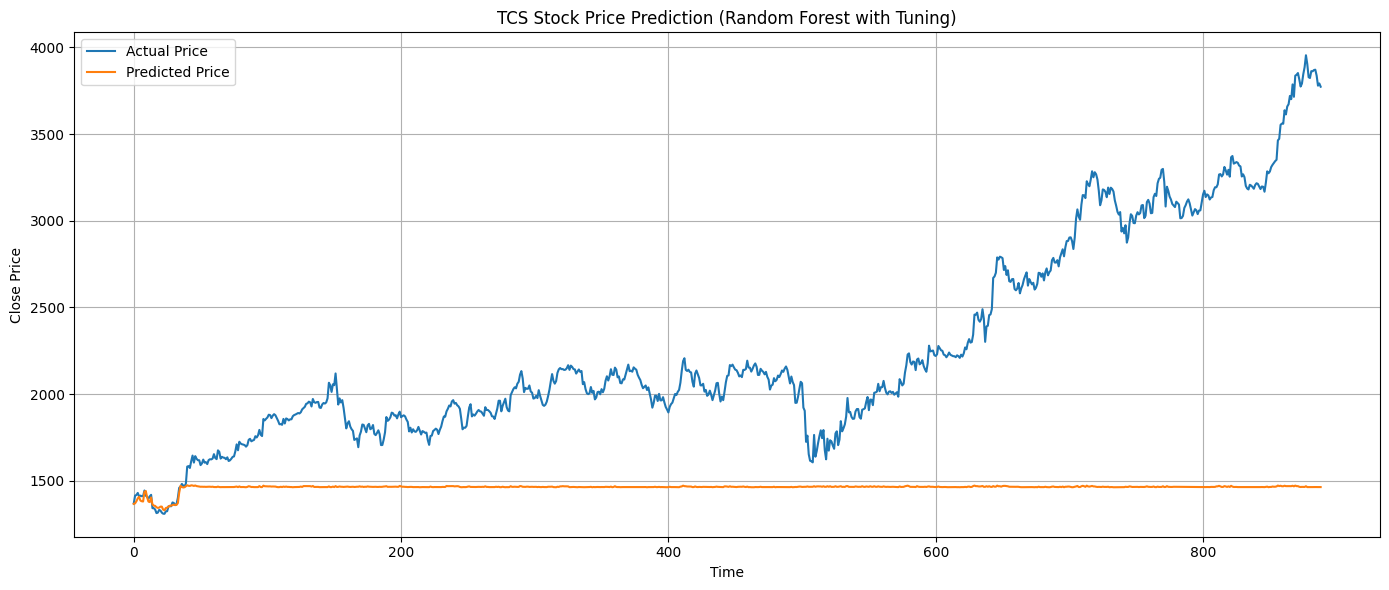

In [35]:
# Train/Test Split
split_index = int(len(df_merged) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Grid Search for Best Parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title("TCS Stock Price Prediction (Random Forest with Tuning)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best Parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error: 807.13
R2 Score: -2.20


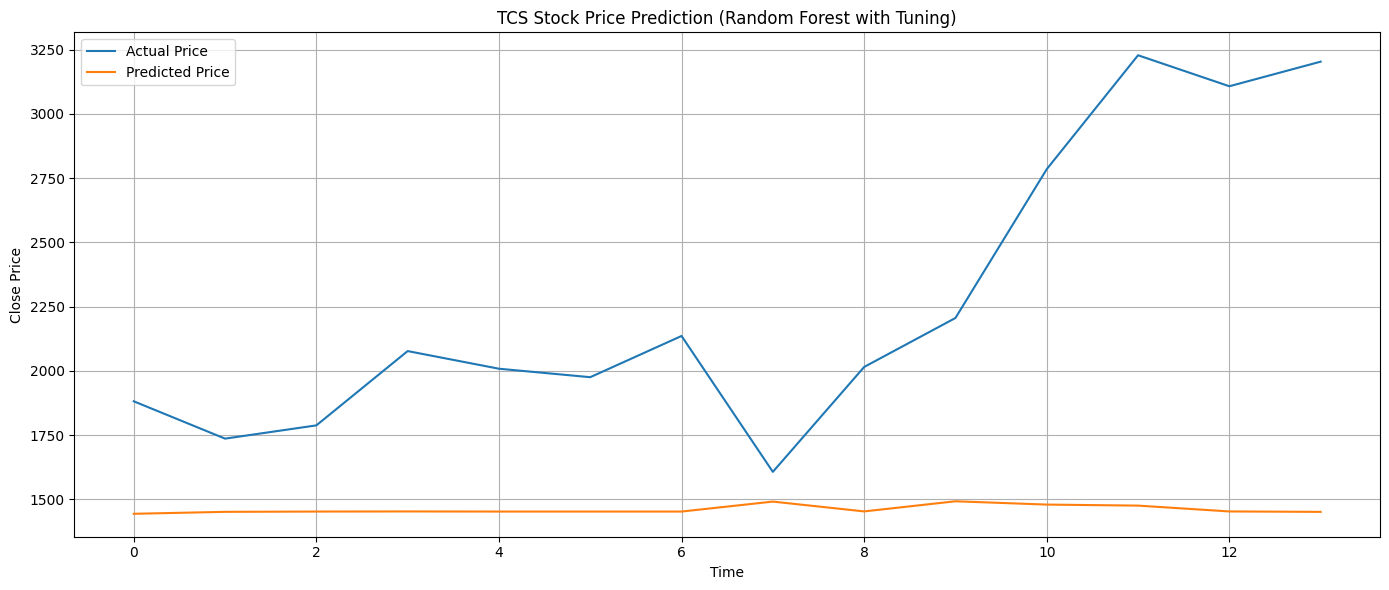

In [ ]:









# Save model
#with open("tcs_rf_optimized.pkl", "wb") as f:
   # pickle.dump((best_model, scaler, features), f)


In [12]:
# Train with deeper trees manually
best_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Manual Model - MAE:", mae)
print("Manual Model - R² Score:", r2)


Manual Model - MAE: 805.0725933837891
Manual Model - R² Score: -2.1793134671950383


Mean Absolute Error: 796.80
R2 Score: -2.14


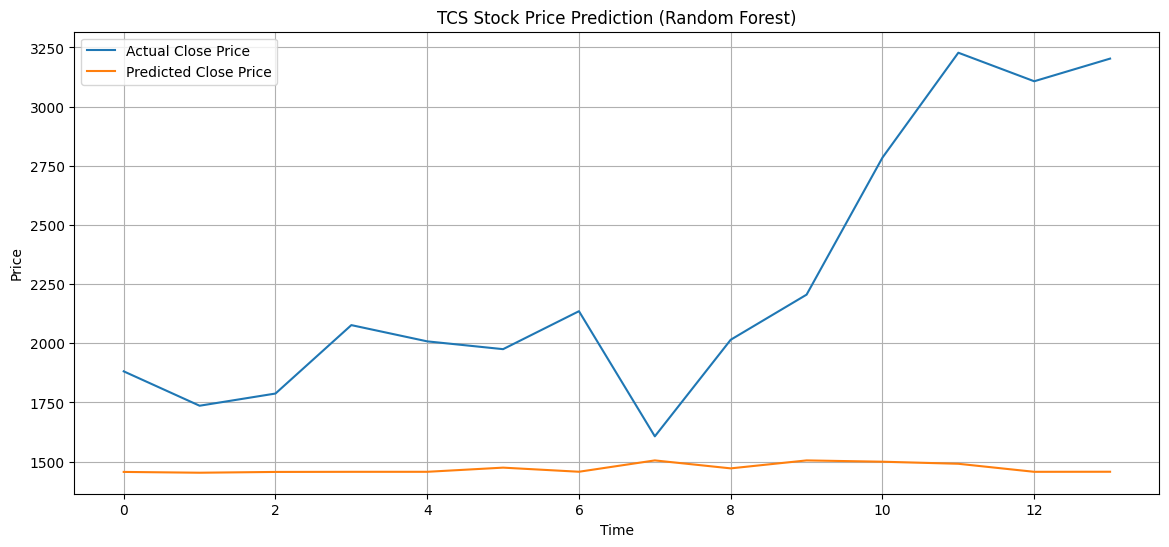

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle

# Load CSV files
df_history = pd.read_csv('TCS_stock_history.csv')
df_action = pd.read_csv('TCS_stock_action.csv')
df_info = pd.read_csv('TCS_stock_info.csv')

# Convert 'Date' columns to datetime
df_history['Date'] = pd.to_datetime(df_history['Date'])
df_action['Date'] = pd.to_datetime(df_action['Date'])

# Sort and merge
df_history.sort_values('Date', inplace=True)
df_action.sort_values('Date', inplace=True)
df_merged = pd.merge(df_history, df_action, on='Date', how='left')

# Rename columns to avoid conflicts
df_merged.rename(columns={
    'Dividends': 'Recorded_Dividend',
    'Stock Splits': 'Recorded_Stock_Split',
    'Stock Split': 'Action_Stock_Split'
}, inplace=True)

# Fill missing action columns if they exist
if 'Dividend' in df_merged.columns:
    df_merged['Dividend'] = df_merged['Dividend'].fillna(0)
if 'Stock Split' in df_merged.columns:
    df_merged['Stock Split'] = df_merged['Stock Split'].fillna(0)

# Feature Engineering
def create_features(df):
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    return df

df_merged = create_features(df_merged)
df_merged.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'Returns', 'MA5', 'MA20', 'Volatility']
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_merged[features])
scaled_target = df_merged[target].values

# Train/Test Split
train_size = int(len(df_merged) * 0.8)
X_train = scaled_features[:train_size]
X_test = scaled_features[train_size:]
y_train = scaled_target[:train_size]
y_test = scaled_target[train_size:]

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plot Predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price')
plt.title('TCS Stock Price Prediction (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Save Model
with open('tcs_rf_model.pkl', 'wb') as f:
    pickle.dump((model, scaler, features), f)
